In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
import requests
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
import re
from IPython.display import display
from scipy.sparse.linalg import svds

### 0.1 - Load and Prepare Data

In [126]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/data/inferred_genres.csv")
genre_descriptors = pd.read_csv(wd + "/data/inferred_genre_top_words.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres.drop(columns="title"), how="left", on="book_id")

In [127]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [128]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/data/goodreads_library_export.csv")

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating", "Title"]]\
    .rename(columns={"Book Id":"book_id", "My Rating":"rating", "Title":"title"}).query("rating > 0")

# Reformat to fit sparse matrix
my_books_1 = pd.merge(my_books, df_books[["book_id", "title"]], how="left", on="book_id", suffixes=["_mb","_dfb"])
my_books_id_match = my_books_1[~my_books_1["title_dfb"].isna()]

my_books_2 = pd.merge(
    my_books_1[my_books_1["title_dfb"].isna()], df_books[["book_id", "title"]], 
    how="left", left_on="title_mb", right_on="title", suffixes=["_mb","_dfb"]
    )

my_books_match_on_title = my_books_2[~my_books_2["title"].isna()]
my_books_id_match = my_books_id_match[["book_id", "rating", "title_dfb"]].rename(columns={"title_dfb":"title"})
my_books_match_on_title = my_books_match_on_title[["book_id_dfb", "rating", "title"]].rename(columns={"book_id_dfb":"book_id"})

my_books_3 = pd.concat([my_books_id_match, my_books_match_on_title])
my_books_4 = pd.merge(book_index, my_books_3, how="left", on="book_id").fillna(0.)
my_books = np.array(my_books_4["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])

# # Replace 0 with 0.000001 to prevent cosine similarities from zeroing
# sparse_fill = 0.000001
# df_reviews.data[df_reviews.data == 0] = sparse_fill

# Normalize reviews within users
norm = Normalizer()
df_reviews = norm.fit_transform(df_reviews) 

### 1.1 - User:User Collaborative Filtering with KNN

In [129]:
target = df_reviews.shape[0] - 1

In [130]:
# Function to use KNN to find similar users
def find_neighbors(n_neighbors, target_user, ratings_df, ind_books, books):

    # Instantiate KNN
    n_neighbors = n_neighbors

    nn_model = NearestNeighbors(
        metric="cosine",
        algorithm="auto",
        n_neighbors=n_neighbors,
        n_jobs=-1
    )

    # Fit to sparse matrix
    nn_model.fit(ratings_df)

    # Feed in user and get neighbors and distances
    reader = ratings_df[target,:].toarray()
    dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

    similar_users = pd.DataFrame(
        [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(columns={0:"user", 1:"distance"}
    )

    # Get all books read by similar users
    book_ind = []
    book_rat = []
    uid = []
    target_user_books = []
    target_user_book_rat = []
    for nt in similar_users.itertuples():
        user = ratings_df[int(nt.user),:].toarray()
        book_inds = np.where(user[0] > 0)[0]
        ratings = user[0][np.where(user[0] > 0)[0]]
        for i in range(len(book_inds)):        
            book_ind.append(book_inds[i])
            book_rat.append(ratings[i])
            uid.append(nt.user)    
            if nt.distance < 0.000000001:
                target_user_books.append(book_inds[i])
                target_user_book_rat.append(ratings[i])

    neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(columns={0:"uid",1:"book_index",2:"user_rating"})

    # Join overall rating for each book
    neighbor_user_ratings = pd.merge(ind_books.reset_index(), neighbor_user_ratings, how="inner", left_on="index", right_on="book_index")
    neighbor_user_ratings = pd.merge(neighbor_user_ratings, books, how="inner", on="book_id")

    # Filter out books target reader has already read
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
    neighbor_user_ratings.drop(["index"], axis=1, inplace=True)

    # Filter out later volumes in series using regex pattern
    regex1 = r"#([3-9]|[1-9]\d+)"
    regex2 = r"Vol. ([0-9]|[1-9]\d+)"
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains("#1-")]

    # View target user's ratings
    target_user_ratings = pd.DataFrame([target_user_books, target_user_book_rat]).T.rename(columns={0:"book_index",1:"user_rating"})
    target_user_ratings = pd.merge(ind_books.reset_index(), target_user_ratings, how="inner", left_on="index", right_on="book_index")
    target_user_ratings = pd.merge(target_user_ratings, books, how="inner", on="book_id")    

    return neighbor_user_ratings, target_user_ratings

In [131]:
n_neighbors = 100
neighbor_user_ratings, target_user_ratings = find_neighbors(n_neighbors, target, df_reviews, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_29355/2867291065.py:56: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_29355/2867291065.py:57: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]


In [132]:
# View neighbors rating table
neighbor_user_ratings.head()

,book_id,uid,book_index,user_rating,title,avg_rating,ratings_count,year,language_code,image_url,...,Genre_16,Genre_17,Genre_18,Genre_19,Genre_20,Genre_21,Genre_22,Genre_23,Genre_24,Genre_25
0,100322,166222.0,1740.0,0.363803,Assata: An Autobiography,4.47,11057.0,1999,eng,https://images.gr-assets.com/books/1328857268m...,...,0.005139,0.005139,0.005139,0.005139,0.005139,0.005139,0.005139,0.005139,0.005139,0.005139
1,10127019,182052.0,8108.0,0.229039,The Lean Startup: How Today's Entrepreneurs Us...,4.04,95622.0,2011,en-US,https://images.gr-assets.com/books/1333576876m...,...,0.005015,0.005015,0.005015,0.005015,0.005015,0.005015,0.005015,0.005015,0.005015,0.005015
2,10182027,12967.0,12405.0,0.237171,The Girl's Guide to Homelessness: A Memoir,3.22,1727.0,2011,en-US,https://images.gr-assets.com/books/1299723800m...,...,0.005562,0.005562,0.005562,0.005562,0.005562,0.005562,0.005562,0.005562,0.005562,0.005562
3,10235,14822.0,16375.0,0.421076,Mountains Beyond Mountains: The Quest of Dr. P...,4.21,53936.0,2003,eng,https://s.gr-assets.com/assets/nophoto/book/11...,...,0.004412,0.004412,0.004412,0.004412,0.004412,0.004412,0.004412,0.004412,0.004412,0.004412
4,10290675,174067.0,20352.0,0.356034,"Electrified Sheep: Glass-Eating Scientists, Nu...",3.70,351.0,2011,NaN,https://images.gr-assets.com/books/1332785557m...,...,0.009713,0.766891,0.009713,0.009713,0.009713,0.009713,0.009713,0.009713,0.009713,0.009713


### 1.2 - Generate Recommendations from Similar Readers

In [133]:
# 20 most popular books among similar readers
popular_recs = neighbor_user_ratings.groupby(["title", "avg_rating", "ratings_count", "year"])["book_id"]\
    .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
    .nlargest(20, "book_id").rename(columns={"book_id":"percent_similar_users_read"})

popular_recs["percent_similar_users_read"] = (popular_recs["percent_similar_users_read"] / n_neighbors).map('{:.1%}'.format)

popular_recs

,title,avg_rating,ratings_count,year,percent_similar_users_read
177,"The Reluctant Queen (The Queens of Renthia, #2)",4.06,684.0,2017,2.0%
197,"Things Fall Apart (The African Trilogy, #1)",3.61,203559.0,1994,2.0%
94,New Boy,3.52,2029.0,2017,2.0%
116,Secrets of a Side Bitch 4,4.60,838.0,2015,1.0%
207,Topaz,4.59,875.0,1997,1.0%
115,Secrets of a Side Bitch 3,4.58,1181.0,2014,1.0%
114,Secrets of a Side Bitch 2,4.54,1419.0,2013,1.0%
125,Spaceman: An Astronaut's Unlikely Journey to U...,4.54,990.0,2016,1.0%
181,The Simone Campbell Story: Secrets of a Side B...,4.54,449.0,2014,1.0%
215,War's Unwomanly Face,4.52,1182.0,1988,1.0%


In [134]:
# 10 highest rated books among similar readers
highest_rated_recs = neighbor_user_ratings.groupby(["title", "avg_rating", "ratings_count", "year"])["book_id"]\
    .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
    .nlargest(20, "avg_rating").rename(columns={"book_id":"percent_similar_users_read"})

highest_rated_recs["percent_similar_users_read"] = (highest_rated_recs["percent_similar_users_read"] / n_neighbors).map('{:.1%}'.format)
highest_rated_recs

,title,avg_rating,ratings_count,year,percent_similar_users_read
116,Secrets of a Side Bitch 4,4.60,838.0,2015,1.0%
207,Topaz,4.59,875.0,1997,1.0%
115,Secrets of a Side Bitch 3,4.58,1181.0,2014,1.0%
114,Secrets of a Side Bitch 2,4.54,1419.0,2013,1.0%
125,Spaceman: An Astronaut's Unlikely Journey to U...,4.54,990.0,2016,1.0%
181,The Simone Campbell Story: Secrets of a Side B...,4.54,449.0,2014,1.0%
215,War's Unwomanly Face,4.52,1182.0,1988,1.0%
74,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,2015,1.0%
16,Assata: An Autobiography,4.47,11057.0,1999,1.0%
221,"Who We Are (Bear, Otter, and the Kid, #2)",4.47,4184.0,2012,1.0%


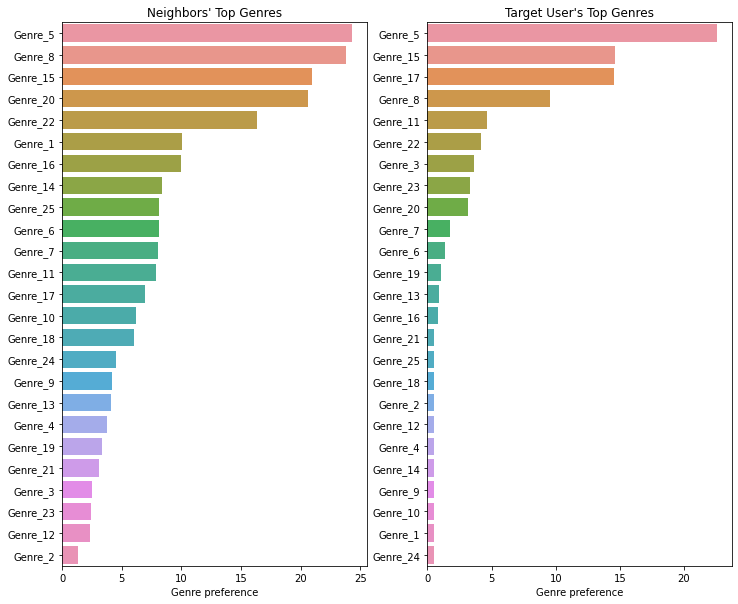

In [135]:
# Plot neighbors top genres
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,10))
genre_ranking = pd.DataFrame(neighbor_user_ratings.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
sns.barplot(
    data=genre_ranking,
    y=genre_ranking.index,
    x=0,
    ax=ax[0]
)
ax[0].set_xlabel("Genre preference")
ax[0].set_title("Neighbors' Top Genres")

# Plot target reader's top genres
genre_ranking = pd.DataFrame(target_user_ratings.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
sns.barplot(
    data=genre_ranking,
    y=genre_ranking.index,
    x=0,
    ax=ax[1]
)
ax[1].set_xlabel("Genre preference")
ax[1].set_title("Target User's Top Genres")
plt.show()

In [136]:
# Loop through genres in descending relevance order and print top recs
for genre in genre_ranking.index[0:5]:
    
    g = float(genre[6:])
    highest_rated_recs_genre = neighbor_user_ratings.query("main_genre == @g")\
        .groupby(["title", "avg_rating", "ratings_count", "year", "url"])["book_id"]\
        .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
        .rename(columns={"book_id":"percent_similar_users_read"})

    highest_rated_recs_genre["percent_similar_users_read"] = highest_rated_recs_genre["percent_similar_users_read"] / n_neighbors
    highest_rated_recs_genre = highest_rated_recs_genre.query("ratings_count > 400 & avg_rating > 3.9")

    # Print genre name and descriptor
    for nt in genre_descriptors.itertuples():
        genre_rep = genre.replace("_"," ")
        if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
            print(nt.genre_string)
            
    display(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(15))
    print("_____\n")

Genre 5: ['history', 'war', 'political', 'account', 'world', 'year', 'country', 'family', 'century', 'people']


,title,avg_rating,ratings_count,url
23,War's Unwomanly Face,4.52,1182.0,https://www.goodreads.com/book/show/4025275-wa...
10,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,https://www.goodreads.com/book/show/24611623-i...
0,Assata: An Autobiography,4.47,11057.0,https://www.goodreads.com/book/show/100322.Assata
24,Why I Am An Atheist: An Autobiographical Disco...,4.45,866.0,https://www.goodreads.com/book/show/1389596.Wh...
16,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,https://www.goodreads.com/book/show/27220736-s...
11,"March: Book One (March, #1)",4.34,21092.0,https://www.goodreads.com/book/show/17346698-m...
7,First They Killed My Father: A Daughter of Cam...,4.30,18580.0,https://www.goodreads.com/book/show/4373.First...
20,The Silk Roads: A New History of the World,4.25,3022.0,https://www.goodreads.com/book/show/25812847-t...
8,Fortune is a Woman,4.21,992.0,https://www.goodreads.com/book/show/355715.For...
13,Pachinko,4.18,8161.0,https://www.goodreads.com/book/show/29983711-p...


_____

Genre 15: ['history', 'poem', 'essay', 'text', 'century', 'collection', 'world', 'writing', 'introduction', 'literature']


,title,avg_rating,ratings_count,url
17,The Invention of Nature: Alexander von Humbold...,4.29,4817.0,https://www.goodreads.com/book/show/23995249-t...
13,Srikanta,4.23,1004.0,https://www.goodreads.com/book/show/1417962.Sr...
3,Feminism is for Everybody: Passionate Politics,4.18,7740.0,https://www.goodreads.com/book/show/168484.Fem...
16,The I Ching or Book of Changes,4.18,12937.0,https://www.goodreads.com/book/show/534289.The...
4,Gaviotas: A Village to Reinvent the World,4.17,555.0,https://www.goodreads.com/book/show/136893.Gav...
6,Guns,4.17,3687.0,https://www.goodreads.com/book/show/17284577-guns
9,Natasha's Dance: A Cultural History of Russia,4.16,2039.0,https://www.goodreads.com/book/show/97401.Nata...
21,The World of Downton Abbey,4.11,5504.0,https://www.goodreads.com/book/show/11489145-t...
19,The Purity Myth: How America's Obsession with ...,4.06,5741.0,https://www.goodreads.com/book/show/4914761-th...
0,Alice in Wonderland,4.03,346530.0,https://www.goodreads.com/book/show/13023.Alic...


_____



Genre 17: ['alien', 'planet', 'world', 'human', 'ship', 'space', 'war', 'crew', 'mission', 'race']


,title,avg_rating,ratings_count,url
0,"By Schism Rent Asunder (Safehold, #2)",4.10,5410.0,https://www.goodreads.com/book/show/2381756.By...
6,"The Light Fantastic (Discworld, #2; Rincewind #2)",3.94,76808.0,https://www.goodreads.com/book/show/34506.The_...
5,"The Clockwork Universe: Isaac Newton, the Roya...",3.91,3763.0,https://www.goodreads.com/book/show/9449985-th...


_____

Genre 8: ['guide', 'people', 'way', 'help', 'practical', 'world', 'experience', 'offer', 'question', 'business']


,title,avg_rating,ratings_count,url
12,The (7L) The Seven Levels of Communication: Go...,4.33,482.0,https://www.goodreads.com/book/show/9858250-th...
21,Totto-chan: The Little Girl at the Window,4.30,14456.0,https://www.goodreads.com/book/show/328802.Tot...
0,"""I Give You My Body . . ."": How I Write Sex Sc...",4.21,481.0,https://www.goodreads.com/book/show/30719827-i...
6,Mountains Beyond Mountains: The Quest of Dr. P...,4.21,53936.0,https://www.goodreads.com/book/show/10235.Moun...
1,Continuous Delivery: Reliable Software Release...,4.15,1748.0,https://www.goodreads.com/book/show/8686650-co...
24,What Is Life? with Mind and Matter and Autobio...,4.14,2817.0,https://www.goodreads.com/book/show/162780.Wha...
19,Things No One Will Tell Fat Girls: A Handbook ...,4.06,1488.0,https://www.goodreads.com/book/show/24796533-t...
16,The Lean Startup: How Today's Entrepreneurs Us...,4.04,95622.0,https://www.goodreads.com/book/show/10127019-t...
18,The Rational Optimist: How Prosperity Evolves,3.98,4894.0,https://www.goodreads.com/book/show/7776209-th...
11,Thank You for Being Late: An Optimist's Guide ...,3.96,3010.0,https://www.goodreads.com/book/show/26114127-t...


_____

Genre 11: ['fiction', 'collection', 'world', 'literary', 'young', 'funny', 'short', 'comedy', 'horror', 'debut']


,title,avg_rating,ratings_count,url


_____



### 2.1 - User:Item Collaborative Filtering with Matrix Factorization

In [137]:
# Find larger number of similar users than before to get broad pool of potentially relevant books
large_neighborhood_ratings, target_user_ratings = find_neighbors(2000, target, df_reviews, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_29355/2867291065.py:56: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_29355/2867291065.py:57: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]


In [138]:
# Get unique users and books to slice df_reviews
neighbor_index = large_neighborhood_ratings["uid"].unique()
neighbor_index = np.append(neighbor_index, target)
neighbor_book_index = large_neighborhood_ratings["book_index"].unique()
neighbor_book_index = np.append(neighbor_book_index, target_user_ratings["book_index"].unique())

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, neighbor_book_index]
R = R[neighbor_index, :]

In [139]:
# Decompose user ratings matrix R
U, sigma, Vt = svds(R, k=5)
sigma = np.diag(sigma)

U = sparse.csr_matrix(U)
sigma = sparse.csr_matrix(sigma)
Vt = sparse.csr_matrix(Vt)

### 2.2 - Generating Recommendations by Making Rating Predictions from Matrix Factorization

In [140]:
# Get predictions
all_user_predicted_ratings = U.dot(sigma) @ Vt
df_preds = pd.DataFrame(all_user_predicted_ratings.toarray(), columns=neighbor_book_index, index=neighbor_index).reset_index()

In [141]:
# Get target user's top predicted ratings
target_pred_books = df_preds[df_preds["index"] == target].columns[1:]
target_pred_ratings = df_preds[df_preds["index"] == target].values[0][1:]

# Put into df with relevant info from df_books
top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                .sort_values(by="predicted_rating", ascending=False)\
                .merge(book_index.reset_index(), left_on="book_index", right_on="index")\
                .merge(df_books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre","url"]], on="book_id")\
                .drop(columns=["index", "book_id"])

# Filter out already read books
top_preds = top_preds[~top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]
top_preds.drop(["book_index"], axis=1, inplace=True)
top_preds.query("avg_rating > 3.9").head(20)

,predicted_rating,title,avg_rating,ratings_count,year,main_genre,url
5,0.010459,I Am Malala: The Story of the Girl Who Stood U...,4.07,228884.0,2013,5.0,https://www.goodreads.com/book/show/17851885-i...
7,0.008074,"A Clash of Kings (A Song of Ice and Fire, #2)",4.40,534960.0,2002,22.0,https://www.goodreads.com/book/show/10572.A_Cl...
8,0.006290,Night (The Night Trilogy #1),4.30,708754.0,1958,20.0,https://www.goodreads.com/book/show/1617.Night
9,0.005370,Wonder (Wonder #1),4.43,255461.0,2012,16.0,https://www.goodreads.com/book/show/11387515-w...
11,0.004775,The Gunslinger,3.98,346978.0,1982,3.0,https://www.goodreads.com/book/show/43615.The_...
12,0.004714,"I, Robot (Robot #0.1)",4.17,201196.0,2004,17.0,https://www.goodreads.com/book/show/41804.I_Robot
13,0.004662,Bad Feminist,3.91,43988.0,2014,16.0,https://www.goodreads.com/book/show/18813642-b...
15,0.004614,Freakonomics: A Rogue Economist Explores the H...,3.94,529274.0,2006,8.0,https://www.goodreads.com/book/show/1202.Freak...
17,0.004141,Mom & Me & Mom,4.15,10192.0,2013,20.0,https://www.goodreads.com/book/show/15798797-m...
20,0.003709,"The Pillars of the Earth (Kingsbridge, #1)",4.29,471990.0,2002,7.0,https://www.goodreads.com/book/show/5043.The_P...


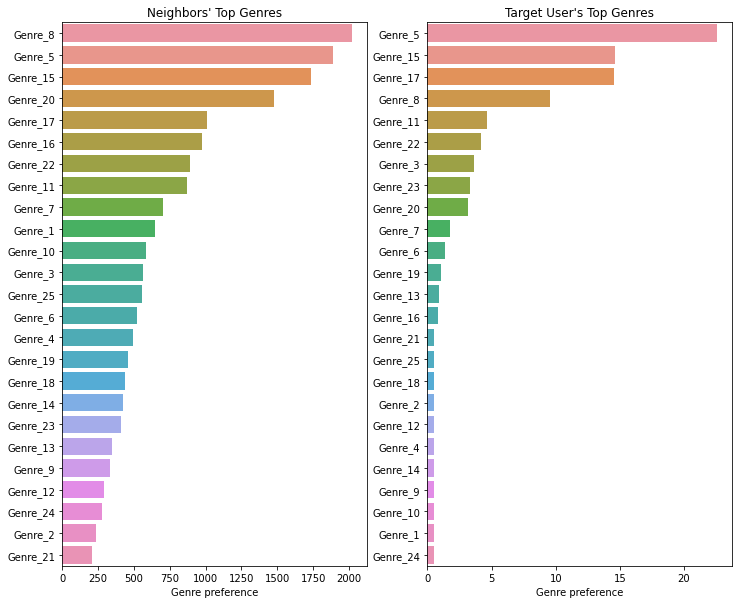

In [142]:
# Plot neighbors top genres
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,10))
genre_ranking = pd.DataFrame(large_neighborhood_ratings.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
sns.barplot(
    data=genre_ranking,
    y=genre_ranking.index,
    x=0,
    ax=ax[0]
)
ax[0].set_xlabel("Genre preference")
ax[0].set_title("Neighbors' Top Genres")

# Plot target reader's top genres
genre_ranking = pd.DataFrame(target_user_ratings.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
sns.barplot(
    data=genre_ranking,
    y=genre_ranking.index,
    x=0,
    ax=ax[1]
)
ax[1].set_xlabel("Genre preference")
ax[1].set_title("Target User's Top Genres")
plt.show()

In [143]:
# Loop through genres in descending relevance order and print top recs
for genre in genre_ranking.index[0:5]:
    
    g = float(genre[6:])
    highest_rated_pred_genre = top_preds.query("main_genre == @g")\
        .sort_values(by="predicted_rating", ascending=False)\
        .query("ratings_count > 400 & avg_rating >= 4.15")\

    # Print genre name and descriptor
    for nt in genre_descriptors.itertuples():
        genre_rep = genre.replace("_"," ")
        if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
            print(nt.genre_string)
    
    display(highest_rated_pred_genre[["title", "avg_rating", "ratings_count","url"]].iloc[0:20,:])
    print("_____\n")

Genre 5: ['history', 'war', 'political', 'account', 'world', 'year', 'country', 'family', 'century', 'people']


,title,avg_rating,ratings_count,url
32,Persepolis: The Story of a Childhood (Persepol...,4.23,119470.0,https://www.goodreads.com/book/show/9516.Perse...
35,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,https://www.goodreads.com/book/show/27220736-s...
54,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,https://www.goodreads.com/book/show/24611623-i...
70,The New Jim Crow: Mass Incarceration in the Ag...,4.49,24694.0,https://www.goodreads.com/book/show/6792458-th...
78,Hitler's Empire: How the Nazis Ruled Europe,4.16,1591.0,https://www.goodreads.com/book/show/3039027-hi...
80,"March: Book One (March, #1)",4.34,21092.0,https://www.goodreads.com/book/show/17346698-m...
101,We Wish to Inform You That Tomorrow We Will Be...,4.29,19564.0,https://www.goodreads.com/book/show/11472.We_W...
114,Pachinko,4.18,8161.0,https://www.goodreads.com/book/show/29983711-p...
124,Tears We Cannot Stop: A Sermon to White America,4.34,2498.0,https://www.goodreads.com/book/show/31421117-t...
133,"The Prize: The Epic Quest for Oil, Money, and ...",4.40,5329.0,https://www.goodreads.com/book/show/169354.The...


_____

Genre 15: ['history', 'poem', 'essay', 'text', 'century', 'collection', 'world', 'writing', 'introduction', 'literature']


,title,avg_rating,ratings_count,url
23,Arguably: Selected Essays,4.19,6061.0,https://www.goodreads.com/book/show/10383597-a...
33,Why Evolution Is True,4.16,15226.0,https://www.goodreads.com/book/show/4005310-wh...
43,Memoirs of Hadrian,4.25,8321.0,https://www.goodreads.com/book/show/12172.Memo...
75,Palestine,4.20,10082.0,https://www.goodreads.com/book/show/769712.Pal...
100,The Road to the Dark Tower: Exploring Stephen ...,4.29,32867.0,https://www.goodreads.com/book/show/452157.The...
128,In the Shadow of Young Girls in Flower (In Sea...,4.40,4461.0,https://www.goodreads.com/book/show/28385.In_t...
144,The Roman Revolution,4.25,483.0,https://www.goodreads.com/book/show/167913.The...
158,Guns,4.17,3687.0,https://www.goodreads.com/book/show/17284577-guns
181,A Field Guide to American Houses,4.28,679.0,https://www.goodreads.com/book/show/1013972.A_...
246,The Philip K. Dick Reader,4.28,2511.0,https://www.goodreads.com/book/show/14183.The_...


_____

Genre 17: ['alien', 'planet', 'world', 'human', 'ship', 'space', 'war', 'crew', 'mission', 'race']


,title,avg_rating,ratings_count,url
12,"I, Robot (Robot #0.1)",4.17,201196.0,https://www.goodreads.com/book/show/41804.I_Robot
52,The Ultimate Hitchhiker's Guide to the Galaxy,4.38,225626.0,https://www.goodreads.com/book/show/13.The_Ult...
61,"Caliban's War (The Expanse, #2)",4.29,41459.0,https://www.goodreads.com/book/show/12591698-c...
256,"Live Free or Die (Troy Rising, #1)",4.16,6544.0,https://www.goodreads.com/book/show/6713634-li...
292,Lost Stars,4.25,9512.0,https://www.goodreads.com/book/show/25067046-l...
321,Maus I: A Survivor's Tale: My Father Bleeds Hi...,4.35,189288.0,https://www.goodreads.com/book/show/15196.Maus_I
473,"The Walking Dead, Compendium 1",4.43,58434.0,https://www.goodreads.com/book/show/6465707-th...
474,The Dreaming Void,4.18,16512.0,https://www.goodreads.com/book/show/866136.The...
544,Judas Unchained,4.30,21306.0,https://www.goodreads.com/book/show/45244.Juda...
664,Pandora's Star,4.24,28964.0,https://www.goodreads.com/book/show/45252.Pand...


_____

Genre 8: ['guide', 'people', 'way', 'help', 'practical', 'world', 'experience', 'offer', 'question', 'business']


,title,avg_rating,ratings_count,url
85,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,27705.0,https://www.goodreads.com/book/show/18077903-c...
89,How Not to Die: Discover the Foods Scientifica...,4.53,4467.0,https://www.goodreads.com/book/show/25663961-h...
155,Neurosis and Human Growth: The Struggle Toward...,4.22,603.0,https://www.goodreads.com/book/show/130383.Neu...
231,Women Who Run With the Wolves: Myths and Stori...,4.15,21937.0,https://www.goodreads.com/book/show/241823.Wom...
259,The Alphabet Versus the Goddess: The Conflict ...,4.18,1611.0,https://www.goodreads.com/book/show/455992.The...
270,The Hard Thing About Hard Things: Building a B...,4.20,20745.0,https://www.goodreads.com/book/show/18176747-t...
279,Algorithms to Live By: The Computer Science of...,4.16,4639.0,https://www.goodreads.com/book/show/25666050-a...
301,If Grace Is True: Why God Will Save Every Pers...,4.20,956.0,https://www.goodreads.com/book/show/111829.If_...
309,Wit,4.20,10771.0,https://www.goodreads.com/book/show/171201.Wit
333,Bigger Leaner Stronger: The Simple Science of ...,4.16,670.0,https://www.goodreads.com/book/show/15745156-b...


_____

Genre 11: ['fiction', 'collection', 'world', 'literary', 'young', 'funny', 'short', 'comedy', 'horror', 'debut']


,title,avg_rating,ratings_count,url
84,Asterios Polyp,4.19,20053.0,https://www.goodreads.com/book/show/4070095-as...
146,Animal Farm / 1984,4.26,120269.0,https://www.goodreads.com/book/show/5472.Anima...
569,The Essential Dykes to Watch Out For,4.36,6979.0,https://www.goodreads.com/book/show/3189884-th...
945,A Manual for Cleaning Women: Selected Stories,4.17,6863.0,https://www.goodreads.com/book/show/22929586-a...
1363,Love's Executioner and Other Tales of Psychoth...,4.18,14376.0,https://www.goodreads.com/book/show/21027.Love...
1400,The Exploits of Sherlock Holmes,4.41,26933.0,https://www.goodreads.com/book/show/76104.The_...
1499,Cinema Panopticum,4.16,784.0,https://www.goodreads.com/book/show/634790.Cin...
1537,Peter and Alice,4.44,561.0,https://www.goodreads.com/book/show/17347724-p...
1989,A Supposedly Fun Thing I'll Never Do Again: E...,4.28,23746.0,https://www.goodreads.com/book/show/6748.A_Sup...
2218,Ministry of Moral Panic,4.24,557.0,https://www.goodreads.com/book/show/17238889-m...


_____

